In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import random
np.random.seed(1)

Referenced paper: https://arxiv.org/pdf/1707.00943.pdf

### Data Generation Functions

In [2]:
def randWalk(d):
    """
    generates a d-dimensional random walk array 
    d: dimension
    """
    y = 0
    arr = np.zeros(d)
    for i in range(d):
        y += np.random.normal(scale=1)
        arr[i] = y
    arr = arr - np.mean(arr) #making it a zero-mean array
    return(arr)

def smooth(arr, windowLen):
    """
    smooths the array by convolutions. takes a moving average 
    of len 'windowLen'
    
    Arguments:
    arr: the array that would be smoothed
    windowLen: specifies the length of the convolution filter
               which determines the number of points that would
               be averaged to generate a point
    """
    box = np.ones(windowLen)/windowLen
    arrSmooth = np.convolve(arr, box, mode='same')
    return(arrSmooth)

def genSignal(d,smoothingWindowLen=1):
    """
    generates a d-dimensional random walk array, where |array| = d
    
    Arguments: 
    d: dimension of the array
    windowLen: length of the convolutions. Bigger values result in a
               more smooth array.
    """
    np.random.seed()
    arr = smooth(randWalk(d),smoothingWindowLen)
    arr = arr * ((d / (np.sum(arr**2)))**.5)
    return(arr)

Samples of the generated signals

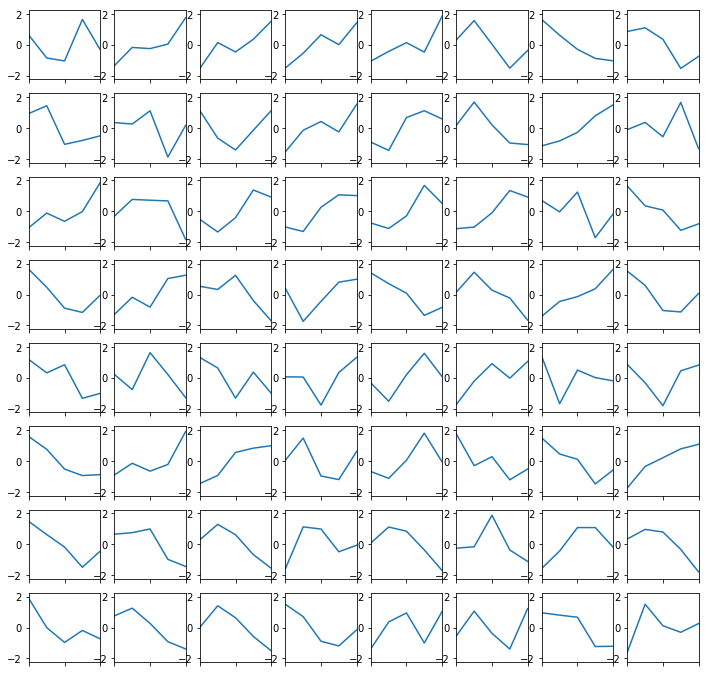

In [3]:
fig = plt.figure(figsize=(12,12))
for i in range(64):
    a = genSignal(d=5)

    ax = fig.add_subplot(8,8,i+1)
    #ax.set_yticklabels([]); 
    ax.set_xticklabels([])
    ax.set_xlim([0, a.size-1]) #ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([-2.25, 2.25])
    plt.plot(a)

### Cyclic Shifts and Noise 

We will use the signal below to demonstrate the data generation process. Let $x \in \mathbb{R}^5$ be a signal. It is generated as follows:
 - First we generate vector $x' \in \mathbb{R}^5$ such that $x'_1 \sim N(0,1)$ and $(x'_i - x'_{i-1} ) \sim N(0,1)$ for $i \in \{2,5\}$. 
 - Then we make $x'$ a zero mean array by subtracting the mean.
 - As this random walk array is generated randomly, ||x'|| is different for each sample $x'$. We generate the final signal $x$ by rescaling $x'$ so that $||x|| = \sum_{i=1}^5 (x_i)^2 = 5$
 - The observations would be generated by applying random cyclic shifts and adding gaussian noise to the underlying signal $x$. Observations that we have are $y^1,y^2, \ldots, y^n$, which are $n$ independent copies of $y \in \mathbb{R}^5$ given by: $$y^i=R_i X + \sigma \xi, \qquad i \in \{1 \ldots n\}, y^i\in \mathbb{R}^5 $$ where the $j$th coordinate after the cyclic shift $R_i x$ is given by $(R_i x)_j := x_{j+u {} \text{(mod 5)}}$, and where $u$ follows the discrete uniform distribution over the set $\{0,1, \ldots, 4\}$. Additionaly $\xi \sim N(0,I_d)$
 
The process is illustrated below with an example.

Underlying signal:

x: [ 1.73361041 -0.16775768 -0.27504661 -1.37262774  0.08182162]
|x|:5.00


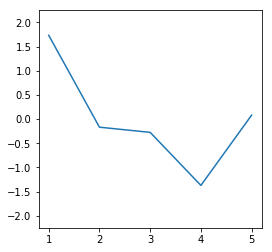

In [4]:
temp_arr = genSignal(d=5)
fig = plt.figure(figsize=(4,4))
plt.plot(np.arange(temp_arr.size)+1,temp_arr)
plt.ylim(-2.25,2.25)
print("x: " + str(temp_arr))
print("|x|:{:.2f}".format(np.sum(np.square(temp_arr))))

In the plots below, blue lines represent $R x$, the signal after a random cyclic shift is applied. Red points represents the observations and are generated by adding a gaussian noise $N(0,4)$ to each coordinate of $R x$. Note that the $SNR = \frac{\sigma_x^2}{\sigma_{noise}^2} = 4$

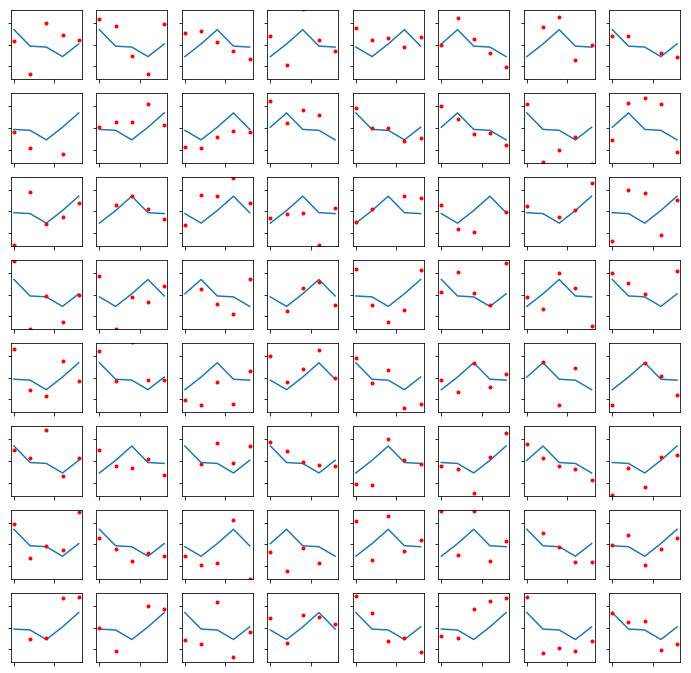

In [5]:
fig = plt.figure(figsize=(12,12))
for i in range(64):
    # random cyclic shift
    if i == 0:
        arrShifted = temp_arr
    else:
        arrShifted = np.roll(temp_arr,np.random.randint(temp_arr.size))
    # random gaussian noise
    a = arrShifted + np.random.normal(scale=2,size=temp_arr.size)

    ax = fig.add_subplot(8,8,i+1)
    ax.set_yticklabels([]); 
    ax.set_xticklabels([])#ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([-4, 4])
    plt.plot(arrShifted)
    plt.plot(a,'or',markersize=3)

# Training and Evaluation

In [6]:
import numpy as np
import tensorflow as tf
import datetime
import multiprocessing as mp
from multiprocessing.pool import ThreadPool
from src import *

In [7]:
def dense(x, scope, num_h, n_x):
    """
    Standard affine layer
    
    scope = name tf variable scope
    num_h = number of hidden units
    num_x = number of input units
    """
    with tf.variable_scope(scope):
        w = tf.get_variable('w', [n_x, num_h], initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [num_h], initializer=tf.constant_initializer(0))
        return tf.matmul(x, w)+b


    
def conv(x, scope, filter_h,filter_w, n_kernel, stride_h=1,stride_w=1, padding='SAME'):
    """
    Convolutional layer
    
    scope        = name tf variable scope
    filter_h     = height of the receptive field
    filter_w     = width of the receptive field
    n_kernel     = # of kernels
    stride_h     = stride height
    stride_w     = stride width
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        n_x = x.get_shape().as_list()[-1]
        w = tf.get_variable('w',
                            [filter_h, filter_w, n_x, n_kernel],
                            initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [n_kernel], initializer=tf.constant_initializer(0))
        return tf.nn.convolution(x, w, padding=padding, strides=[stride_h, stride_w])+b    


def bnorm(X,isTraining,scope='batch_norm',axis=-1):
    """
    Batch normalization layer
    
    X          = input
    isTraining = True during training, False otherwise.
    axis       = axis for normalization
    scope      = name tf variable scope
    
    """
    return(tf.layers.batch_normalization(
        inputs=X,
        axis=axis, 
        training = isTraining,
        name=scope
    ))
    
def convObservations(X,batch_size,n_images,isTraining=False, reuse=False):
    """
    Makes convolutions over noisy signals with cyclic shifts.
    X.size = (batch_size,nObservations, signalDim,1 ). Returns the average 
    value of the encodings of the observations
    """

    with tf.variable_scope('convObservations', reuse=reuse):
        h = tf.nn.leaky_relu(conv(X, 'conv0',1,5,32,1,1), 0.2)  # 5x64
        h = bnorm(h,isTraining,'bnorm_1d_0')
        h = tf.nn.leaky_relu(conv(h, 'conv1',1,3,64,1,1), 0.2)  # 5x64
        h = bnorm(h,isTraining,'bnorm_1d_1')
        h = tf.nn.leaky_relu(conv(h, 'conv2',1,3,64,1,2), 0.2)  # 3x128
        h = bnorm(h,isTraining,'bnorm_1d_2')
        h = tf.nn.leaky_relu(conv(h, 'conv3',1,3,128,1,2), 0.2)  # 2x128
        h = bnorm(h,isTraining,'bnorm_1d_3')
        h = tf.reshape(h, [-1, 256])
        
        h = tf.nn.leaky_relu(dense(h, 'fc_0', 128,256), 0.2)
        h = bnorm(h,isTraining,'bnorm_1d_fc0')
        h = tf.nn.leaky_relu(dense(h, 'fc_1', 128,128), 0.2)
        h = bnorm(h,isTraining,'bnorm_1d_fc1')
        h = tf.reshape(h, [-1, n_images, 128]) 

        h = tf.reduce_mean(h, 1)
        return(h)        


    
def decodeSignal(X, batch_size, enc_dim = 128, isTraining=False, reuse=False):
    """
    Takes encoding produced by the observations as input and
    generates a the underlying true signal
    """
    with tf.variable_scope('decodeSignal', reuse=reuse):
        h = tf.nn.leaky_relu(dense(X, 'hz0', num_h=128,n_x=enc_dim), 0.2)
        h = bnorm(h,isTraining,'bnorm_hz0')
        h = tf.nn.leaky_relu(dense(h, 'hz1', num_h=64,n_x=128), 0.2)
        h = bnorm(h,isTraining,'bnorm_hz1')
        h = tf.nn.leaky_relu(dense(h, 'hz2', num_h=16,n_x=64), 0.2)
        h = bnorm(h,isTraining,'bnorm_hz2')
        h = tf.nn.leaky_relu(dense(h, 'hz3', num_h=5,n_x=16), 0.2)
        h = bnorm(h,isTraining,'bnorm_hz3')
        h = dense(h, 'hz4', num_h=5,n_x=5)
        
        return(h)    
    

class objGenNetwork(object):
    """
    Implementation of the model
    """
    def __init__(self,
                 signalDim = 5,
                 nObservationsPerSignal = 64,
                 noise = 2,
                 minibatchSize = 64,
                 testSampleSize = 1000,
                 lr = 0.001,
                 training = True,
                 skipStep = 1,
                 vers='v1'
                ):
        self.signalDim = signalDim
        self.nObservationsPerSignal = nObservationsPerSignal
        self.noise = noise
        self.minibatchSize = minibatchSize
        self.testSampleSize = testSampleSize
        self.lr = lr
        self.isTraining = training
        self.skipStep = skipStep
        self.vers = vers
        
        self.gstep = tf.Variable(0, 
                                 dtype=tf.int32, 
                                 trainable=False,
                                 name='global_step')
        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None

    def data_generator(self,trainingBatch=True):

        """
        Generates batches of random signals and their noisy 
        observations with cyclic shifts. |Signal| = dim(Signal)
        """
        minibatchSize = self.minibatchSize
        testSampleSize = self.testSampleSize
        signalDim = self.signalDim
        noise = self.noise
        nObservationsPerSignal=self.nObservationsPerSignal
        
        
        batches = minibatchSize if trainingBatch else testSampleSize


        arrs = [genSignal(d=signalDim).astype('float32') for i in range(batches)]
        arrShifted = np.array([np.roll(a,np.random.randint(signalDim)) \
                               + np.random.normal(scale=noise,size=signalDim) 
                               for a in arrs for i in range(nObservationsPerSignal)])
        arrShifted= np.reshape(arrShifted,(batches,nObservationsPerSignal,signalDim))

        arrs = np.array([np.roll(a,i) for a in arrs for i in range(signalDim)])
        arrs= np.reshape(arrs,(batches,signalDim,signalDim))

        batch_x = np.expand_dims(arrShifted,axis=3)
        batch_y = arrs #np.expand_dims(arrs,axis=3)
        

        if trainingBatch:
            self.train_x_new = batch_x
            self.train_y_new = batch_y
        else:
            self.test_x_new = batch_x
            self.test_y_new = batch_y
        
        
    def inference(self):
        h = convObservations(self.x_ph, 
                             self.minibatchSize,
                             self.nObservationsPerSignal,
                             isTraining=self.isTraining
                            )
        self.preds = decodeSignal(h, 
                                  self.minibatchSize,
                                  isTraining=self.isTraining
                                 )

        
    def loss(self):
        """
        Defines loss function
        We use mean squared loss over the predicted and the true signal
        under the best fitting cyclic shift.
        """
        # 
        with tf.name_scope('loss'):
            tiled_preds = tf.tile(tf.expand_dims(self.preds, 1),[1,self.signalDim,1])
            entropy = tf.squared_difference(self.y_ph,tiled_preds)
            entropy = tf.reduce_sum(entropy, axis = 2)
            entropy = tf.reduce_min(entropy,axis = 1)
            self.loss = tf.reduce_mean(entropy, name='loss')

    def optimize(self):
        """
        Optimization op
        """
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.opt = tf.train.AdamOptimizer(self.lr).minimize(self.loss, 
                                                                   global_step=self.gstep)

    def eval_graph(self):
        """
        Takes the most accurate rotation of the true object
        as reference and calculates the average accuracy of
        the occupancy grid of the object
        """
        with tf.name_scope('prediction_eval'):
            tiledPreds = tf.tile(tf.expand_dims(self.preds, 1),
                                 [1,self.signalDim,1])
            MAE = tf.reduce_sum(tf.abs(tiledPreds - self.y_ph),
                                axis = 2)
            MAE = tf.reduce_min(MAE,axis=1)
            self.MAE = tf.reduce_mean(MAE,name="MAE")
        
        
    def eval_once(self, sess, writer, epoch, step):
        self.isTraining = False
        MAE_batch, loss_batch, summaries = sess.run(
            [self.MAE,
             self.loss,
             self.summary_op],
            feed_dict={self.x_ph: self.test_x_new,
                       self.y_ph: self.test_y_new}
        )
        writer.add_summary(summaries, global_step=step)
        print('test MAE at step {0}: {1} '.format(step,MAE_batch))
        print('test loss at step {0}: {1} '.format(step,loss_batch))
        


    def summary(self):
        """
        Summary for TensorBoard
        """
        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', self.loss)
            tf.summary.scalar('MAE', self.MAE)
            tf.summary.histogram('histogram loss', self.loss)
            self.summary_op = tf.summary.merge_all()

    def build(self):
        """
        Builds the computation graph
        """
        self.x_ph = tf.placeholder(tf.float32, [None, 
                                                None,
                                                self.signalDim,
                                                1]) 
        self.y_ph = tf.placeholder(tf.float32, [None,
                                                self.signalDim,
                                                self.signalDim])
        self.data_generator()
        self.inference()
        self.loss()
        self.optimize()
        self.eval_graph()
        self.summary()
    
    def train_one_epoch(self, sess, saver, writer, epoch, step):
#        start_time = time.time()
        self.isTraining = True
        _, l, summaries = sess.run([self.opt, 
                                    self.loss,
                                    self.summary_op],
                                   feed_dict={self.x_ph: self.train_x_new,
                                              self.y_ph: self.train_y_new})
        writer.add_summary(summaries, global_step=step)
        #if (step + 1) % self.skipStep == 0:
        #    print('training Loss at step {0}: {1}'.format(step, l))
        step += 1
        saver.save(sess, 'checkpoints/cryoem_'+self.vers+'/cpoint', global_step=step)
#        print('Average loss at epoch {0}: {1}'.format(epoch, l))
#        print('Took: {0} seconds'.format(time.time() - start_time))
        return step

    def train(self, n_epochs):
        """
        Calls the training ops and prepares the training data
        for the next batch in a parallel process.
        """
        safe_mkdir('checkpoints')
        safe_mkdir('checkpoints/cryoem_'+self.vers)
        writer = tf.summary.FileWriter('./graphs/cryoem_'+self.vers, tf.get_default_graph())

        tVars = tf.trainable_variables()
        defGraph = tf.get_default_graph()

        for v in defGraph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES): 
            if (('bnorm_' in v.name) and
                ('/Adam' not in v.name) and
                ('Adagrad' not in v.name) and
                (v not in tVars )):
                tVars.append(v)
                
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            saver = tf.train.Saver(var_list= tVars)
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem_'+self.vers+'/cpoint'))

            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
            
            step = self.gstep.eval()

            for epoch in range(n_epochs):
                self.train_x = self.train_x_new
                self.train_y = self.train_y_new
                
                pool = ThreadPool(processes=1)
                async_result = pool.apply_async(self.data_generator,())
                step = self.train_one_epoch(sess, saver, writer, epoch, step)
                pool.close()
                pool.join()

                if (step + 1) % self.skipStep == 0:
                    self.data_generator(trainingBatch=False)
                    self.eval_once(sess, writer, epoch, step)
                    
                    
        writer.close()
        self.isTraining = False


In [8]:
# Note that the data generation process would utilize 4 CPU
# threads. If the model would train on GPU, you may set the
# 'nProcess_dataprep' argument equal to 'mp.cpu_count()'
model = objGenNetwork(noise=2,
                      nObservationsPerSignal=32,
                      lr=.001,                   
                      minibatchSize = 80,
                      testSampleSize=1024,
                      skipStep = 25,
                      vers='5D_sigma2_obs60_moreVariance')
model.build()


INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [13]:
#model.skipStep=30
model.lr = 0.0001
model.minibatchSize = 128
#model.nObservationsPerSignal=256
model.train(n_epochs=100)


INFO:tensorflow:Restoring parameters from checkpoints/cryoem_5D_sigma2_obs60_moreVariance/cpoint-100
test MAE at step 24: 2.2123327255249023 
test loss at step 24: 1.5365750789642334 
test MAE at step 49: 2.2297182083129883 
test loss at step 49: 1.5383968353271484 
test MAE at step 74: 2.214526891708374 
test loss at step 74: 1.5291908979415894 
test MAE at step 99: 2.1876296997070312 
test loss at step 99: 1.4893780946731567 


# Sample Results

parameter loading

In [14]:
with tf.Session() as sess:    
    
    sess.run(tf.global_variables_initializer())
    tVars = tf.trainable_variables()
    defGraph = tf.get_default_graph()

    for v in defGraph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES): 
        if (('bnorm_' in v.name) and
                ('/Adam' not in v.name) and
                ('Adagrad' not in v.name) and
                (v not in tVars )):
                tVars.append(v)

    saver = tf.train.Saver(var_list= tVars)
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/cryoem_'+model.vers+'/cpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    y_pred = sess.run(model.preds,feed_dict={model.x_ph: model.train_x_new})


INFO:tensorflow:Restoring parameters from checkpoints/cryoem_5D_sigma2_obs60_moreVariance/cpoint-100


#### sample results:

In [17]:
for k in range(10):
    print('\nsample: ' + str(k))

    print('true signal: ' + str(y_pred[k]))
    min_err = 999999999999
    min_ind=0
    for ind, a in enumerate(model.train_y_new[k]):
        err = np.sum(np.square(a - y_pred[k]))
        if err <= min_err:
            min_err = err
            min_ind = ind
    print('pred signal: '+ str(+ model.train_y_new[k][min_ind]))


sample: 0
true signal: [-1.2599463  -0.45490578  0.17610523  0.52710366  1.0107262 ]
pred signal: [-1.1774529  -1.049908    0.95958304  0.00664585  1.261132  ]

sample: 1
true signal: [ 0.5950714  -0.55127734 -0.78672194 -0.596308    1.3346184 ]
pred signal: [ 0.91945356 -1.4655511  -0.90710545  0.47359407  0.97960883]

sample: 2
true signal: [-1.0483435  -0.6314929  -0.30128974  0.82315946  1.1578945 ]
pred signal: [-1.8099328  -0.27894738  0.34775695  0.93999326  0.80113   ]

sample: 3
true signal: [-0.24212895 -0.23161556  0.11800733 -0.8537881   1.2042181 ]
pred signal: [-1.0007473   0.44581184 -0.58680326 -0.6131144   1.7548531 ]

sample: 4
true signal: [ 1.0618715   0.43291324 -0.96957445 -1.1572095   0.6289012 ]
pred signal: [ 1.2431786 -0.7652988 -1.0157121 -0.6510083  1.1888405]

sample: 5
true signal: [-0.5565102  -0.07477291  0.45158592 -1.2763878   1.4493611 ]
pred signal: [-0.34806824 -0.72792375  1.321592   -1.2568657   1.0112658 ]

sample: 6
true signal: [ 0.48011005 -0